# AdaBoost

## Dataset importing

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

def load_data_set(data_set_name: str) -> (np.array, np.array):
    print("loading %s" % data_set_name)
    data = np.genfromtxt("/content/drive/My Drive/Colab Notebooks/adaboost/%s.csv" % data_set_name, dtype=None, delimiter=',', names=True)
    print("columns", data.dtype.names)

    objects = np.array([np.array(i.tolist())[:-1] for i in data], dtype=float)
    classes = np.array([i[data.dtype.names.index('class')] for i in data])
    new_classes = np.array([i.decode('utf-8') == 'P' for i in classes])
    print(" loaded")
    return (objects, new_classes)
        

datasets = [(name, load_data_set(name)) for name in ["chips", "geyser"]]


loading chips
columns ('x', 'y', 'class')
 loaded
loading geyser
columns ('x', 'y', 'class')
 loaded


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """


## Solution

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier
from math import log, exp
from random import random

def create_stump(xs: np.array, ys: np.array, depth: int, weights) -> (DecisionTreeClassifier, float, np.array):
    if weights is None:
        weights = np.array([1 / len(xs) for _ in range(len(xs))])

    dtc = DecisionTreeClassifier(max_depth=depth)
    dtc.fit(xs, ys, weights)

    negative = [i for i in range(len(xs)) if predict([(dtc, 1.0)], xs[i]) != ys[i]]
    totalError = sum(weights[i] for i in negative) + 1e-15
    amountOfSay = 0.5 * log((1 - totalError) / totalError)

    newWeight = [weights[i] * exp(amountOfSay if i in negative else -amountOfSay) for i in range(len(weights))]
    newWeightSum = sum(newWeight)
    newWeight = [x / newWeightSum for x in newWeight]
    return (dtc, amountOfSay, np.array(newWeight))

def gen_stumps(xs: np.array, ys: np.array, depth: int, levels: int, weights=None) -> list:
    if levels == 0:
        return []

    dtc, aos, newWeight = create_stump(xs, ys, depth, weights)
    return [(dtc, aos)] + gen_stumps(xs, ys, depth, levels - 1, newWeight)

def predict(stumps: list, x: np.array) -> bool:
    results = [dtc.predict(np.array([x])) for dtc, _ in stumps]

    positive, negative = 0, 0
    for i in range(len(results)):
        if results[i]:
            positive += stumps[i][1]
        else:
            negative += stumps[i][1]
    return positive > negative

## Graphic utilities

In [70]:
import matplotlib.pyplot as plt

graph_width = 2

def add_dependency_plot(title, xlabel, ylabel, results, launches=2):
    global graph_index
    graph_index += 1
    ax = plt.subplot(launches, graph_width, graph_index)
    ax.title.set_text(title)
    plt.plot([x for _, x in results], [y for y, _ in results])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ybound(0.0, 1.0)
    ax.set_xbound(results[0][1], results[-1][1])
    plt.grid(True)

def add_graphic(x, y, title, stumps: list, launches=2, ncols=graph_width, h=.05):
    global graph_index
    graph_index += 1

    X0, X1 = x[:, 0], x[:, 1]
    x_min, x_max = X0.min() - 0.5, X0.max() + 0.5
    y_min, y_max = X1.min() - 0.5, X1.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    ax = plt.subplot(launches, ncols, graph_index)
    ax.title.set_text(title)

    z = [[predict(stumps, np.array([i, j])) for i, j in zip(ii, jj)] for ii, jj in zip(xx, yy)]
    out = ax.contourf(xx, yy, np.array(z), cmap=plt.cm.coolwarm, alpha=0.8)

    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xticks(())
    ax.set_yticks(())
    plt.grid(True)

def show(graph_width=2):
    plt.subplots_adjust(top=2.0 * graph_index / graph_width, bottom=0, left=0, right=2, hspace=0.5, wspace=0.4)
    plt.show()

## Graphics

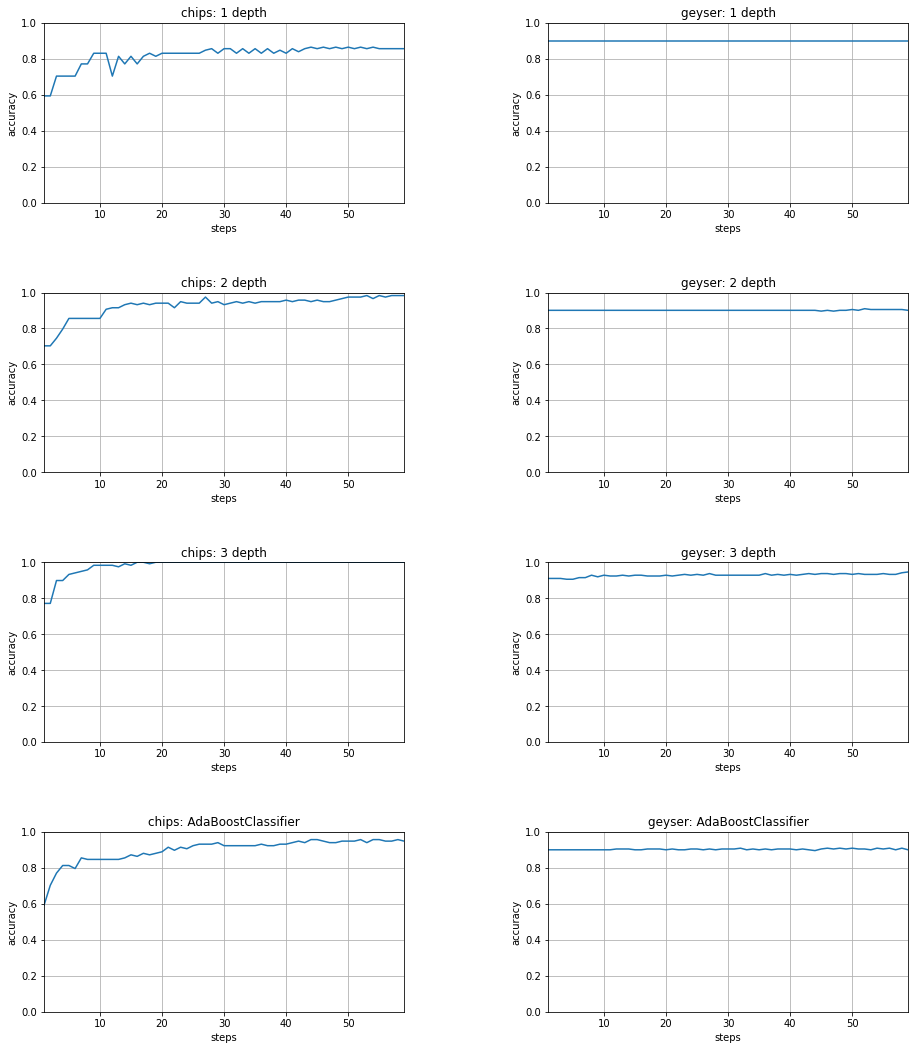

In [76]:
graph_index = 0

depths = [1, 2, 3]

launches = len(depths) + len(stumpQuantity) + 2

stumpList = []

for depth in depths:
  for name, (xs, ys) in datasets:
      stumps = gen_stumps(xs, ys, depth, 60)
      stumpList.append(stumps)
      scores = [(accuracy_score(ys, [predict(stumps[:i], x) for x in xs]), i) for i in range(1, 60)]
      add_dependency_plot(f"{name}: {depth} depth", "steps", "accuracy", scores, launches)

for name, (xs, ys) in datasets:
    scores = []
    for i in range(1, 60):
        abc = AdaBoostClassifier(n_estimators=i)
        abc.fit(xs, ys)
        scores.append((accuracy_score(ys, abc.predict(xs)), i))
    add_dependency_plot(f"{name}: AdaBoostClassifier", "steps", "accuracy", scores, launches)

show(1.25)

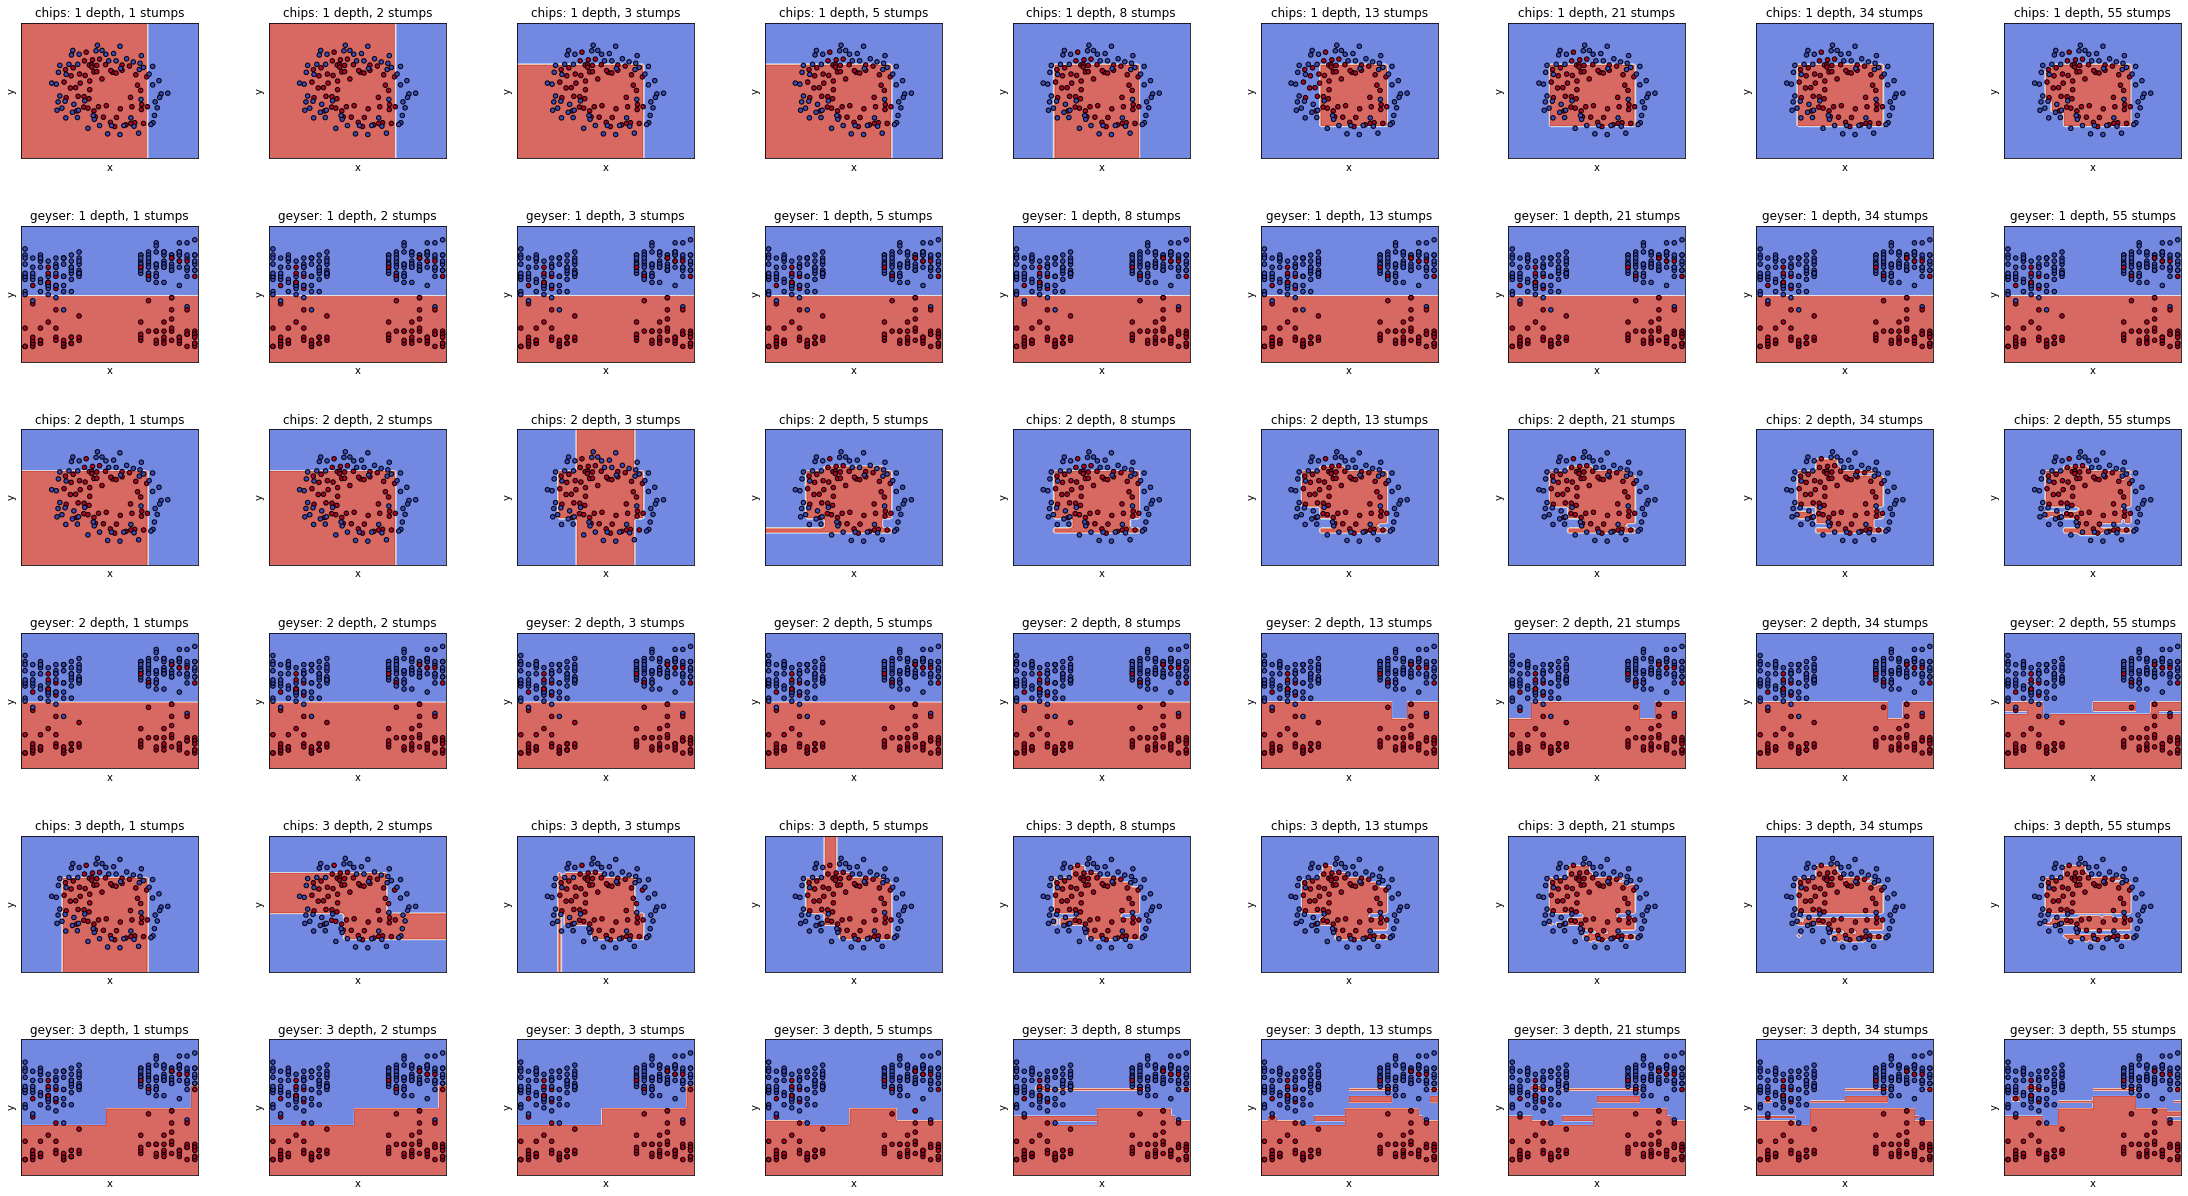

In [81]:
graph_index = 0

stumpQuantity = [1, 2, 3, 5, 8, 13, 21, 34, 55]

for d in range(len(depths)):
  for i in range(len(datasets)):
      for j in stumpQuantity:
          name, (xs, ys) = datasets[i]
          add_graphic(xs, ys, f"{name}: {depths[d]} depth, {j} stumps", stumpList[d * len(datasets) + i][:j], len(datasets) * len(depths), ncols=len(stumpQuantity))

plt.subplots_adjust(top=4, bottom=0, left=0, right=5, hspace=0.5, wspace=0.4)
plt.show()